In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import loo

SyntaxError: invalid syntax (loo.py, line 6)

In [2]:
f = open('kddcup.names')
columns = f.readlines()
columns = [i.split(':')[0] for i in columns]
columns = columns[1:] + ['outcome']
f.close()

df = pd.read_csv('kddcup.data',header=None,names=columns)
df.reset_index(drop=True,inplace=True)
print(df.shape)
display(df.head())

(4898431, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [3]:
df['outcome'] = df['outcome'].apply(lambda x: x.replace('.',''))
df['binary_outcome'] = df['outcome'].apply(lambda x: 1 if x!= 'normal' else 0)

In [10]:
display(df['binary_outcome'].value_counts().to_frame())
display(df['outcome'].value_counts().to_frame())

,binary_outcome
1,3925650
0,972781


,outcome
smurf,2807886
neptune,1072017
normal,972781
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020
teardrop,979


,dst_host_same_srv_rate
count,4.898431e+06
mean,7.537132e-01
std,4.111860e-01
min,0.000000e+00
25%,4.100000e-01
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


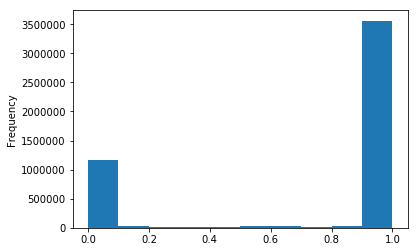

,is_host_login
count,4.898431e+06
mean,4.082940e-07
std,6.389788e-04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


KeyboardInterrupt: 

In [11]:
pd.options.display.max_columns=50
for c in set(df.columns)-set(['outcome','binary_outcome']):
    if(str(df.dtypes[c]) != 'object'):
        display(df[[c]].describe())
        df[c].plot.hist()
        plt.show()
        plt.close()
    else:
        display(df[c].value_counts().to_frame())

In [4]:
# drop these low information variables
df.drop(['is_host_login','num_outbound_cmds','land'],axis=1,inplace=True)

In [5]:
exclude = ['outcome','binary_outcome']
model_vars = list(set(df.columns) - set(exclude))
loo_vars = ['service','flag']

In [6]:
kf = KFold(n_splits=10,random_state=10)
fold = 0
for train,test in kf.split(df):
    df.loc[test,'fold'] = fold
    fold +=1
del fold

In [16]:
#import imp
#imp.reload(loo)

<module 'loo' from 'E:\\jupyter_nb\\kdd1999\\loo.py'>

In [9]:
# cv with gradient boost
for f in range(10):
    print('make LOO')
    %time ltab = loo.loo(df=df.loc[df['fold'] != f,['binary_outcome'] + loo_vars],vars=loo_vars,yvar='binary_outcome')
    print()
    
    print('get LOO columns')
    %time loo_df = ltab.applyLookup(df=df.loc[:,['binary_outcome','fold'] + loo_vars],trainVar='fold',trainValue=[g for g in range(10) if g != f])
    print()
    
    for i in ['loo_' + i for i in loo_vars]:
        df[i] = loo_df[i]
        
    del loo_df,ltab

    display(df.head(20))
    
for i in df.columns:
    if i[:4] == 'loo_':
        del df[i]

make LOO
Wall time: 1.92 s

get LOO columns
Wall time: 25min 4s



,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,binary_outcome,fold,loo_service,loo_flag
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
1,0,tcp,http,SF,162,4528,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
2,0,tcp,http,SF,236,1228,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
3,0,tcp,http,SF,233,2032,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
4,0,tcp,http,SF,239,486,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
5,0,tcp,http,SF,238,1282,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
6,0,tcp,http,SF,235,1337,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
7,0,tcp,http,SF,234,1364,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
8,0,tcp,http,SF,239,1295,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN
9,0,tcp,http,SF,181,5450,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal,0,0.0,NaN,NaN


make LOO
Wall time: 2.47 s

get LOO columns


KeyError: ('the label [http_2784] is not in the [index]', 'occurred at index 896064')